In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, Flatten

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import Data and EDA

In [2]:
df = pd.read_csv('reddit_posts.csv')
print(df.shape)
df.head()

(26688, 53)


,adserver_click_url,adserver_imp_pixel,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,disable_comments,distinguished,...,spoiler,stickied,subreddit,subreddit_id,third_party_tracking,third_party_tracking_2,thumbnail,title,ups,url
0,NaN,NaN,False,johnnyawesome0,NaN,NaN,False,1480697304,NaN,NaN,...,False,False,techsupport,t5_2qioo,NaN,NaN,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,NaN,NaN,False,Silverfin113,NaN,NaN,False,1480697424,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,NaN,NaN,False,bookbooksbooks,NaN,NaN,False,1480697613,NaN,NaN,...,False,False,gamedev,t5_2qi0a,NaN,NaN,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,NaN,NaN,False,[deleted],NaN,NaN,False,1480697634,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,NaN,NaN,False,caffeine_potent,NaN,NaN,False,1480697748,NaN,NaN,...,False,False,learnpython,t5_2r8ot,NaN,NaN,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 53 columns):
adserver_click_url        0 non-null float64
adserver_imp_pixel        0 non-null float64
archived                  26688 non-null bool
author                    26688 non-null object
author_flair_css_class    435 non-null object
author_flair_text         351 non-null object
contest_mode              26688 non-null bool
created_utc               26688 non-null int64
disable_comments          0 non-null float64
distinguished             85 non-null object
domain                    26688 non-null object
downs                     26688 non-null float64
edited                    26688 non-null object
gilded                    26688 non-null float64
hide_score                26688 non-null bool
href_url                  0 non-null float64
id                        26688 non-null object
imp_pixel                 0 non-null float64
is_self                   26688 non-null bool
link_fla

Get rid of the columns where it's mostly all Null

In [4]:
drop_cols = ['adserver_click_url', 'adserver_imp_pixel', 'author_flair_css_class', 
            'author_flair_text', 'disable_comments', 'distinguished', 'href_url', 'imp_pixel',
            'link_flair_css_class', 'link_flair_text', 'media', 'mobile_ad_url', 'original_link',
            'post_hint', 'preview', 'promoted', 'promoted_by', 'promoted_display_name', 'promoted_url',
            'secure_media', 'third_party_tracking', 'third_party_tracking_2']
df = df.drop(drop_cols, axis=1)
print(df.shape)
df.head()

(26688, 31)


,archived,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,...,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,ups,url
0,False,johnnyawesome0,False,1480697304,self.techsupport,0.0,False,0.0,False,5g49s2,...,{},I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,False,Silverfin113,False,1480697424,self.learnprogramming,0.0,False,0.0,False,5g4a5p,...,{},I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,False,bookbooksbooks,False,1480697613,self.gamedev,0.0,False,0.0,False,5g4att,...,{},"I'm writing an article called ""Video Games Tha...",False,False,gamedev,t5_2qi0a,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,False,[deleted],False,1480697634,self.learnprogramming,0.0,1480698462,0.0,False,5g4awr,...,{},[deleted],False,False,learnprogramming,t5_2r7yd,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,False,caffeine_potent,False,1480697748,self.learnpython,0.0,1480709138,0.0,False,5g4bcr,...,{},I have the following representation of argumen...,False,False,learnpython,t5_2r8ot,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 31 columns):
archived              26688 non-null bool
author                26688 non-null object
contest_mode          26688 non-null bool
created_utc           26688 non-null int64
domain                26688 non-null object
downs                 26688 non-null float64
edited                26688 non-null object
gilded                26688 non-null float64
hide_score            26688 non-null bool
id                    26688 non-null object
is_self               26688 non-null bool
locked                26688 non-null bool
media_embed           26688 non-null object
name                  26688 non-null object
num_comments          26688 non-null float64
over_18               26688 non-null bool
permalink             26688 non-null object
quarantine            26688 non-null bool
retrieved_on          26688 non-null float64
saved                 26688 non-null bool
score                 26

Look through rest of columns looking for more things to drop.

In [6]:
drop_cols = []

#### Archived

In [7]:
df.archived.value_counts()

False    26688
Name: archived, dtype: int64

That's useless, drop it.

In [8]:
drop_cols.append('archived')

#### Author

In [9]:
df.author.nunique()

16561

In [10]:
df.author.value_counts()[:10]

[deleted]            5947
wilsonharry           156
AutoModerator          90
ebpnovin               58
angelovstanton         46
Hgbnty                 46
metthewhayden          26
kevindepp142           25
RingSavvy              20
eastpointsoftware      19
Name: author, dtype: int64

I don't think there's enough consistency here to make this column worth using

In [11]:
drop_cols.append('author')

#### Contest Mode

In [12]:
df.contest_mode.value_counts()

False    26683
True         5
Name: contest_mode, dtype: int64

That's useless, drop it.

In [13]:
drop_cols.append('contest_mode')

#### Created UTC

In [14]:
df.created_utc[:10]

0    1480697304
1    1480697424
2    1480697613
3    1480697634
4    1480697748
5    1480697775
6    1480697781
7    1480697827
8    1480697900
9    1480698099
Name: created_utc, dtype: int64

A quick search shows this to be a UNIX timestamp, I'm going to use pandas to create usabel month / year / time data columns from this, and then drop this column.

In [15]:
tmp_utc = pd.to_datetime(df.created_utc, unit='s')

In [16]:
tmp_utc.apply(lambda x: x.year).value_counts()

2016    26688
Name: created_utc, dtype: int64

Everything is in 2016 so that's no good

In [17]:
tmp_utc.apply(lambda x: x.month).value_counts()

12    26688
Name: created_utc, dtype: int64

Same with month, so no point looking at that either.

Going to make columns for the day of the week, and the hour.

In [18]:
tmp_utc.apply(lambda x: x.dayofweek).value_counts()

3    4927
2    3964
4    3923
1    3788
0    3680
6    3236
5    3170
Name: created_utc, dtype: int64

In [19]:
tmp_utc.apply(lambda x: x.hour).value_counts()

19    1504
20    1473
21    1471
22    1452
17    1378
18    1378
16    1330
15    1285
23    1273
1     1229
0     1228
2     1138
3     1118
14    1064
4     1034
5      999
13     938
6      864
12     833
11     775
10     766
7      744
9      735
8      679
Name: created_utc, dtype: int64

In [20]:
df['created_dayofweek'] = tmp_utc.apply(lambda x: x.dayofweek)
df['created_hour'] = tmp_utc.apply(lambda x: x.hour)
drop_cols.append('created_utc')

#### Domain

In [21]:
df.domain.value_counts()

self.techsupport                       11423
self.learnprogramming                   3448
self.learnpython                        1724
self.gamedev                            1191
self.technology                         1152
self.web_design                          749
self.Python                              566
self.javahelp                            536
self.javascript                          482
self.linux                               465
self.engineering                         454
self.csshelp                             393
self.iOSProgramming                      315
self.swift                               249
youtube.com                              188
self.PHP                                 175
self.computerscience                     159
self.compsci                             147
self.java                                138
self.django                              124
self.netsec                               97
self.css                                  94
self.HTML 

Can try to use this for NLP

#### Downs

In [22]:
df.downs.value_counts()

0.0    26688
Name: downs, dtype: int64

Useless, drop it

In [23]:
drop_cols.append('downs')

#### Edited

In [24]:
df.edited.value_counts()

False         23172
1481174981        2
1481225395        2
1481742672        2
1482523021        1
1482185203        1
1480832252        1
1482539687        1
1481287028        1
1481466705        1
1481050092        1
1482193129        1
1481581979        1
1482948540        1
1481755295        1
1481839808        1
1481070073        1
1481924256        1
1481753006        1
1482606231        1
1482797346        1
1480959432        1
1481688599        1
1480959680        1
1481989086        1
1481331420        1
1480835944        1
1482869195        1
1481150951        1
1482206545        1
              ...  
1480897755        1
1480905721        1
1482022542        1
1482954208        1
1482359448        1
1481942503        1
1481215129        1
1481004604        1
1481907418        1
1480800270        1
1482624911        1
1481075431        1
1481044104        1
1482282333        1
1481618577        1
1480785363        1
1481213391        1
1481607136        1
1480991938        1


Appears to be False if not edited, timestamp otherwise, going to change this to a 1 or zero.

In [25]:
df.edited = df.edited.apply(lambda x: 0 if x == "False" else 1)
df.edited.value_counts()

0    23172
1     3516
Name: edited, dtype: int64

#### Gilded

In [26]:
df.gilded.value_counts()

0.0    26678
1.0        8
6.0        1
2.0        1
Name: gilded, dtype: int64

#### Hide Score

In [27]:
df.hide_score.value_counts()

False    26688
Name: hide_score, dtype: int64

Useless, drop it

In [28]:
drop_cols.append('hide_score')

#### id

In [29]:
df.id.nunique()

26688

All unique, doesn't tell us anything

In [30]:
drop_cols.append('id')

#### Is Self

In [31]:
df.is_self.value_counts()

True     24594
False     2094
Name: is_self, dtype: int64

Change from bool to int

In [32]:
df.is_self = df.is_self.apply(lambda x: int(x))

#### locked

In [33]:
df.locked.value_counts()

False    26666
True        22
Name: locked, dtype: int64

Change from bool to int

In [34]:
df.locked = df.locked.apply(lambda x: int(x))

#### Media_embed

In [35]:
df.media_embed.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 26420
{u'content': u'&lt;iframe class="embedly-embed" src="//cdn.embedly.com/widgets/media.html?src=http%3A%2F%2Fwww.youtube.com%2Fembed%2Fvideoseries%3Flist%3DPLeCUCcES3YgWCSSdxWyijd_DT15oAVabz&amp;url=https%3A%2F%2Fwww.youtube.com%2Fplaylist%3Flist%3DPLeCUCcES3YgWCSSdxWyijd_DT15oAVabz&amp;i

Too empty

In [36]:
drop_cols.append('media_embed')

#### name

In [37]:
df.name.nunique()

26688

All unique ids again

In [38]:
drop_cols.append('name')

#### num comments

In [39]:
df.num_comments.value_counts()[:15]

0.0     6855
1.0     4309
2.0     3345
3.0     2307
4.0     1977
5.0     1495
6.0     1187
7.0      888
8.0      691
9.0      555
10.0     403
11.0     340
12.0     266
13.0     234
14.0     201
15.0     165
Name: num_comments, dtype: int64

This is good

#### over 18

In [40]:
df.over_18.value_counts()

False    26647
True        41
Name: over_18, dtype: int64

Change from bool to int

In [41]:
df.over_18 = df.over_18.apply(lambda x: int(x))

#### permalink

In [42]:
df.permalink.nunique()

26688

Another unique column, drop

In [43]:
drop_cols.append('permalink')

#### quarintine

In [44]:
df.quarantine.value_counts()

False    26688
Name: quarantine, dtype: int64

Useless

In [45]:
drop_cols.append('quarantine')

#### retrieved on

In [46]:
df.retrieved_on[:10]

0    1.484297e+09
1    1.484297e+09
2    1.484297e+09
3    1.484297e+09
4    1.484297e+09
5    1.484297e+09
6    1.484297e+09
7    1.484297e+09
8    1.484297e+09
9    1.484297e+09
Name: retrieved_on, dtype: float64

I honestly have no idea if this is relevant, might as well drop it.

In [47]:
drop_cols.append('retrieved_on')

#### saved

In [48]:
df.saved.value_counts()

False    26688
Name: saved, dtype: int64

Use. Less.

In [49]:
drop_cols.append('saved')

#### score

In [50]:
df.score.describe()

count    26688.000000
mean         7.789006
std        216.126418
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      26573.000000
Name: score, dtype: float64

#### secure media embed

In [51]:
df.secure_media_embed.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 26420
{u'content': u'&lt;iframe class="embedly-embed" src="https://cdn.embedly.com/widgets/media.html?src=https%3A%2F%2Fwww.youtube.com%2Fembed%2Fvideoseries%3Flist%3DPLeCUCcES3YgWCSSdxWyijd_DT15oAVabz&amp;url=https%3A%2F%2Fwww.youtube.com%2Fplaylist%3Flist%3DPLeCUCcES3YgWCSSd

In [52]:
drop_cols.append('secure_media_embed')

#### selftext

In [53]:
df.selftext[:10]

0    I have a Sony surround sound system for a blu-...
1    I've written what seems to be a prohibitively ...
2    I'm writing an article called "Video Games Tha...
3                                            [deleted]
4    I have the following representation of argumen...
5    I am about to create a website where users use...
6                                            [deleted]
7    This [post](https://www.reddit.com/r/learnpyth...
8                                            [removed]
9    As the title says. Yesterday I've finally had ...
Name: selftext, dtype: object

#### spoiler

In [54]:
df.spoiler.value_counts()

False    26688
Name: spoiler, dtype: int64

useless

In [55]:
drop_cols.append('spoiler')

#### stickied

In [56]:
df.stickied.value_counts()

False    26687
True         1
Name: stickied, dtype: int64

In [57]:
drop_cols.append('stickied')

#### subreddit

In [58]:
df.subreddit.value_counts()

techsupport         11423
learnprogramming     3448
technology           2321
learnpython          1724
gamedev              1281
web_design            864
Python                603
javascript            546
linux                 545
javahelp              536
engineering           525
csshelp               393
iOSProgramming        330
swift                 261
programming           254
PHP                   192
computerscience       162
netsec                159
java                  157
compsci               154
django                127
css                   106
cpp                    86
HTML                   85
ruby                   77
flask                  71
html5                  62
jquery                 46
pygame                 34
coding                 34
perl                   24
lisp                   16
programmer             13
dailyprogrammer        10
IPython                 8
inventwithpython        6
pystats                 3
pythoncoding            2
Name: subred

#### subreddit id

In [59]:
df.subreddit_id.value_counts()

t5_2qioo    11423
t5_2r7yd     3448
t5_2qh16     2321
t5_2r8ot     1724
t5_2qi0a     1281
t5_2qh1m      864
t5_2qh0y      603
t5_2qh30      546
t5_2qh1a      545
t5_2t1jq      536
t5_2qhpi      525
t5_2roaw      393
t5_2s61a      330
t5_2z6zi      261
t5_2fwo       254
t5_2qh38      192
t5_2qj8o      162
t5_1rqwi      159
t5_2qhd7      157
t5_2qhmr      154
t5_2qh4v      127
t5_2qifv      106
t5_2qi27       86
t5_2r6cd       85
t5_2qh21       77
t5_2s1s3       71
t5_2r7u2       62
t5_2qhs4       46
t5_2rb2y       34
t5_2rkfn       34
t5_2qh5e       24
t5_2qh35       16
t5_2qnoo       13
t5_2tj45       10
t5_2x3ey        8
t5_2tfjk        6
t5_2yw9f        3
t5_3649w        2
Name: subreddit_id, dtype: int64

different version of subreddit, therefore a dube, can drop

In [60]:
drop_cols.append('subreddit_id')

#### thumbnail

In [61]:
df.thumbnail.value_counts()

self       18192
default     8480
nsfw          16
Name: thumbnail, dtype: int64

#### title

In [62]:
df.title[:10]

0                               Help with audio set-up
1                            Optimizing code for speed
2    Seeking Tales of Development Woe (and Triumph)...
3            [Java] Finding smallest value in an array
4                   currying functions using functools
5                              Text Editor integration
6    How can I use (different 'groups' of 8 differe...
7        What are some ways to learn efficient python?
8    Requesting help with moving a file from local ...
9    No screen on startup when display has freesync...
Name: title, dtype: object

#### ups

In [63]:
df.ups.value_counts()[:15]

1.0     15301
0.0      3699
2.0      2784
3.0      1306
4.0       542
5.0       482
6.0       373
7.0       286
8.0       201
9.0       144
10.0      130
11.0      106
12.0       92
13.0       80
14.0       71
15.0       67
Name: ups, dtype: int64

#### url

In [64]:
df.url.nunique()

26547

mostly all unique, drop

In [65]:
drop_cols.append('url')

### Drop these determined columns

In [66]:
df = df.drop(drop_cols, axis=1)
print(df.shape)
df.head()

(26688, 15)


,domain,edited,gilded,is_self,locked,num_comments,over_18,score,selftext,subreddit,thumbnail,title,ups,created_dayofweek,created_hour
0,self.techsupport,0,0.0,1,0,1.0,0,1.0,I have a Sony surround sound system for a blu-...,techsupport,self,Help with audio set-up,1.0,4,16
1,self.learnprogramming,0,0.0,1,0,8.0,0,23.0,I've written what seems to be a prohibitively ...,learnprogramming,self,Optimizing code for speed,23.0,4,16
2,self.gamedev,0,0.0,1,0,5.0,0,12.0,"I'm writing an article called ""Video Games Tha...",gamedev,self,Seeking Tales of Development Woe (and Triumph)...,12.0,4,16
3,self.learnprogramming,1,0.0,1,0,9.0,0,0.0,[deleted],learnprogramming,default,[Java] Finding smallest value in an array,0.0,4,16
4,self.learnpython,1,0.0,1,0,12.0,0,6.0,I have the following representation of argumen...,learnpython,self,currying functions using functools,6.0,4,16


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 15 columns):
domain               26688 non-null object
edited               26688 non-null int64
gilded               26688 non-null float64
is_self              26688 non-null int64
locked               26688 non-null int64
num_comments         26688 non-null float64
over_18              26688 non-null int64
score                26688 non-null float64
selftext             26688 non-null object
subreddit            26688 non-null object
thumbnail            26688 non-null object
title                26688 non-null object
ups                  26688 non-null float64
created_dayofweek    26688 non-null int64
created_hour         26688 non-null int64
dtypes: float64(4), int64(6), object(5)
memory usage: 3.1+ MB


### Adding more Features

Aside from the NLP that would happen, I want to use Textblob to get sentiment and polarity features for both the text and titles.

In [68]:
def get_subjectivity(txt):
    blob = TextBlob(txt)
    return blob.sentiment.subjectivity

def get_polarity(txt):
    blob = TextBlob(txt)
    return blob.sentiment.polarity

In [69]:
df['selftext_subjectivity'] = df.selftext.apply(get_subjectivity)

In [70]:
df['selftext_polarity'] = df.selftext.apply(get_polarity)

In [71]:
df['title_subjectivity'] = df.title.apply(get_subjectivity)

In [72]:
df['title_polarity'] = df.title.apply(get_polarity)

Take a look

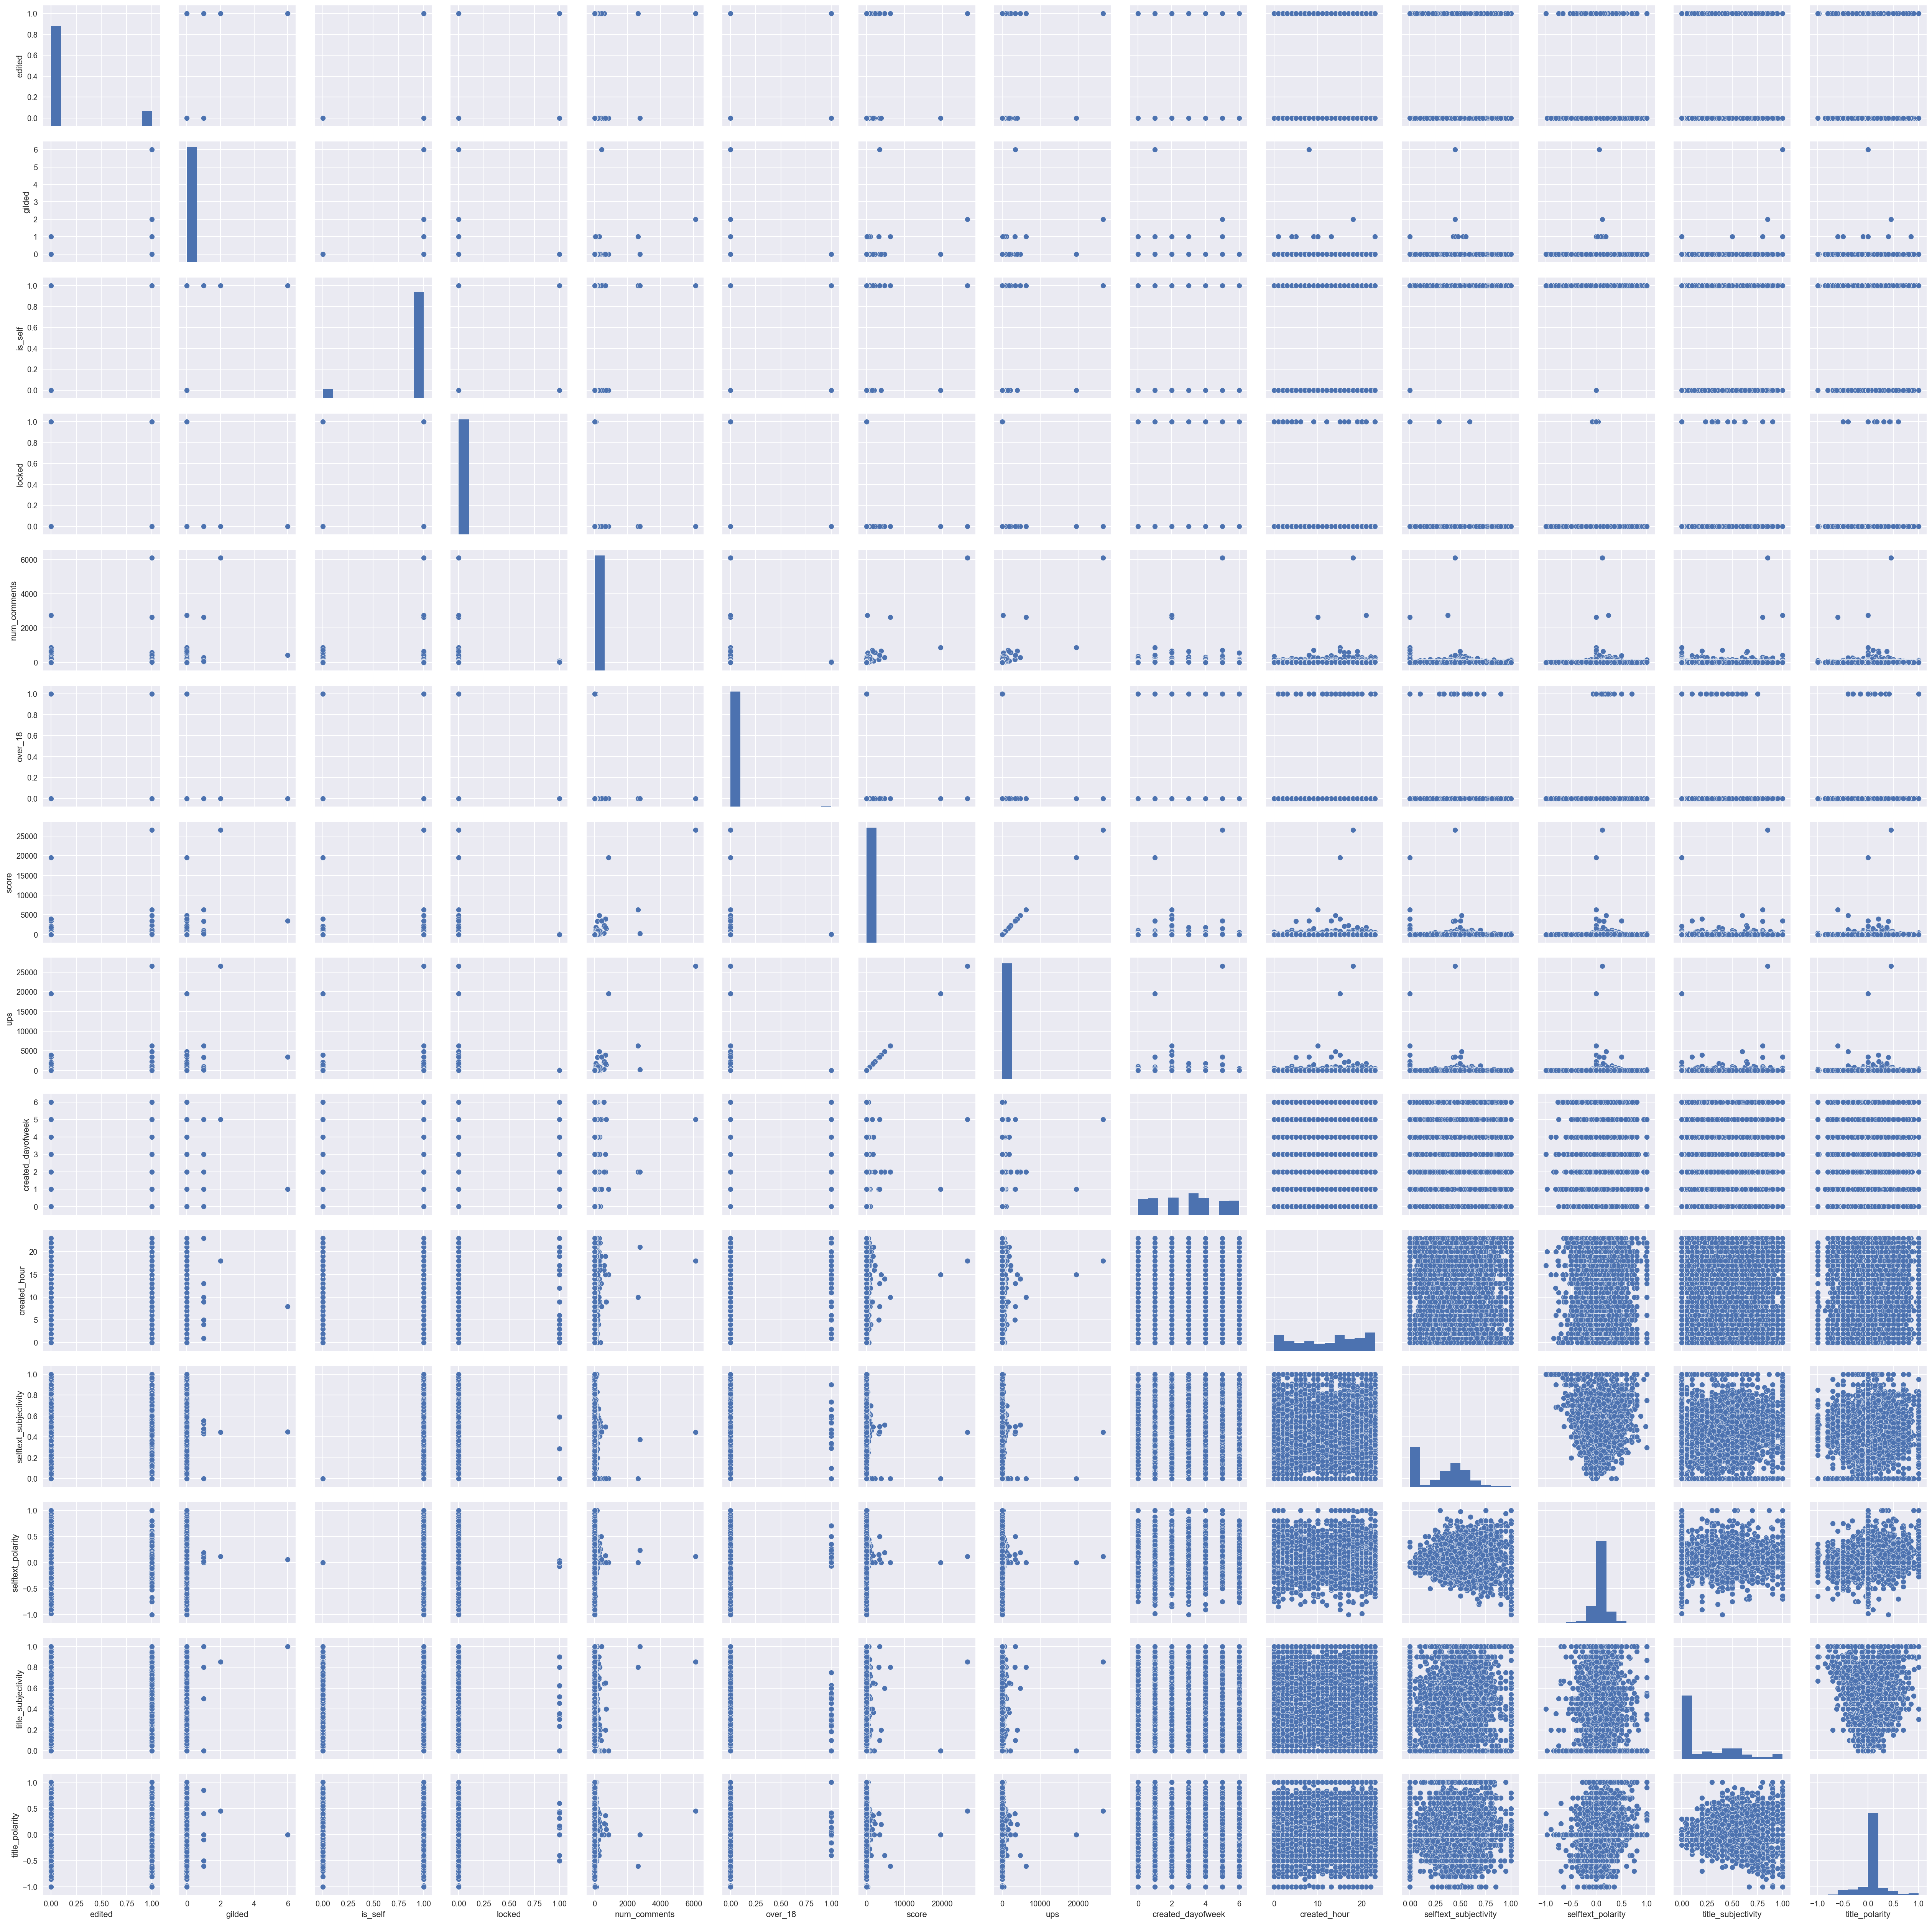

In [73]:
sns.pairplot(df)

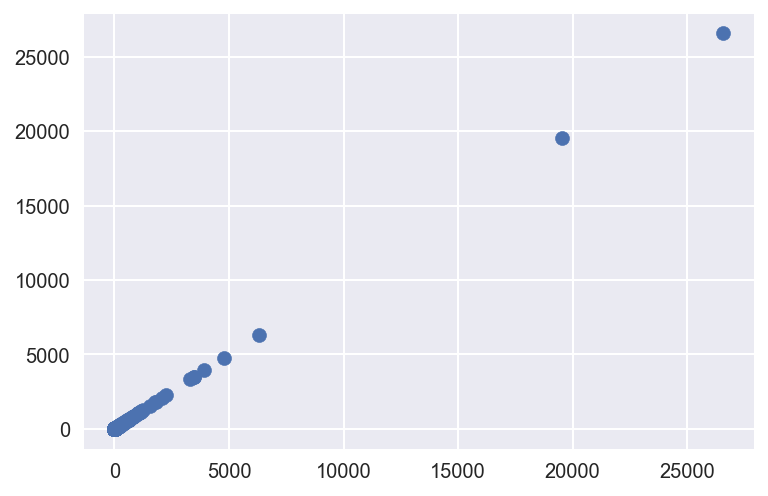

In [74]:
plt.scatter(df.ups, df.ups)

## Goals

Upon conclusion of EDA and cleaning the data a bit I've decided that my goal will be to do a regression model predicting ups which is upvotes. The reason being that getting upvotes is something some people on reddit care a lot about, despite none of the columns looking very predictive of upvotes, I think it would be interesting to use mainly NLP to see if you can predict how much score a post will get.

To this end I will remove the score column, because it is analagous to score, and I will remove num_comments, because from my experience with reddit, number of comments is more a result of having high upvotes than something that leads to having upvotes, and the same goes for gilded. I will also drop locked because locking is something that basically ends a posts lifetime, and therefore would not be predictive how how popular it will become.

A challenge I will face is that there are a few huge outliers for score, and I will need to decide what to do with them.

In [75]:
df = df.drop(['score', 'gilded', 'locked', 'num_comments'], axis=1)
print(df.shape)
df.head()

(26688, 15)


,domain,edited,is_self,over_18,selftext,subreddit,thumbnail,title,ups,created_dayofweek,created_hour,selftext_subjectivity,selftext_polarity,title_subjectivity,title_polarity
0,self.techsupport,0,1,0,I have a Sony surround sound system for a blu-...,techsupport,self,Help with audio set-up,1.0,4,16,0.558333,0.291667,0.0,0.0
1,self.learnprogramming,0,1,0,I've written what seems to be a prohibitively ...,learnprogramming,self,Optimizing code for speed,23.0,4,16,0.370912,0.015735,0.0,0.0
2,self.gamedev,0,1,0,"I'm writing an article called ""Video Games Tha...",gamedev,self,Seeking Tales of Development Woe (and Triumph)...,12.0,4,16,0.393056,-0.030035,0.0,0.0
3,self.learnprogramming,1,1,0,[deleted],learnprogramming,default,[Java] Finding smallest value in an array,0.0,4,16,0.000000,0.000000,0.0,0.0
4,self.learnpython,1,1,0,I have the following representation of argumen...,learnpython,self,currying functions using functools,6.0,4,16,0.355556,-0.038889,0.0,0.0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 15 columns):
domain                   26688 non-null object
edited                   26688 non-null int64
is_self                  26688 non-null int64
over_18                  26688 non-null int64
selftext                 26688 non-null object
subreddit                26688 non-null object
thumbnail                26688 non-null object
title                    26688 non-null object
ups                      26688 non-null float64
created_dayofweek        26688 non-null int64
created_hour             26688 non-null int64
selftext_subjectivity    26688 non-null float64
selftext_polarity        26688 non-null float64
title_subjectivity       26688 non-null float64
title_polarity           26688 non-null float64
dtypes: float64(5), int64(5), object(5)
memory usage: 3.1+ MB


Make a checkpoint by saving the data to a csv

In [107]:
df.to_csv('data_checkpoint.csv', index=False)
df = pd.read_csv('data_checkpoint.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 15 columns):
domain                   26688 non-null object
edited                   26688 non-null int64
is_self                  26688 non-null int64
over_18                  26688 non-null int64
selftext                 26688 non-null object
subreddit                26688 non-null object
thumbnail                26688 non-null object
title                    26688 non-null object
ups                      26688 non-null float64
created_dayofweek        26688 non-null int64
created_hour             26688 non-null int64
selftext_subjectivity    26688 non-null float64
selftext_polarity        26688 non-null float64
title_subjectivity       26688 non-null float64
title_polarity           26688 non-null float64
dtypes: float64(5), int64(5), object(5)
memory usage: 3.1+ MB


The non-static data transformations that has to be done now is NLP for selftext and title, and creating dummies for thumbnail and domain.


butefore doing that I will split my data. I will train test split it twice, the first will create holdout data, providing data that I will use as unseen data, I will label that as holdout. The second split will be for my active use in training and testing my models, and seeing how well they do. 

The workflow will be that using the train / test data to decide on what model to use, fitting it on all non holdout data, and finally come to a conclusion about that model by scoring the first set of holdout data.

The baseline will be to just guess the mean ups.

In [108]:
X = df.drop('ups', axis=1)
y = df.ups

X_fulltrain, X_holdout, y_fulltrain, y_holdout = train_test_split(X, y, test_size=.1, random_state=337)
X_train, X_test, y_train, y_test = train_test_split(X_fulltrain, y_fulltrain, test_size=.25, random_state=337)

print("fulltrain: ", X_fulltrain.shape, y_fulltrain.shape)
print("holdout: ", X_holdout.shape, y_holdout.shape)
print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

fulltrain:  (24019, 14) (24019,)
holdout:  (2669, 14) (2669,)
Train:  (18014, 14) (18014,)
Test:  (6005, 14) (6005,)


To organize my remaining feature engineering, I will use pipelines from here.

Make Baseline

In [143]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
preds = dr.predict(X_test)

print("r2: ", r2_score(y_test, preds))
print("MSE: ", mean_squared_error(y_test, preds))

r2:  -0.000970492100894
MSE:  4974.77556206


The Numeric data can simple be extracted and added to the feature union as is, the below class will be used to do that.

In [110]:
class MultipleFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.cols].values

In [111]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.col]

In [118]:
class toDense(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X.todense()

In [113]:
num_cols = ['edited', 'is_self', 'over_18', 'created_dayofweek', 'created_hour', 
           'selftext_subjectivity', 'selftext_polarity', 'title_subjectivity', 'title_polarity']

num_features = make_pipeline(MultipleFeaturesExtractor(num_cols))

The remaining 5 columns will be put through NLP

In [114]:
domain_feature = make_pipeline(FeatureExtractor('domain'),
                              TfidfVectorizer(stop_words='english'),
                              TruncatedSVD(n_components=20))

In [115]:
selftext_feature = make_pipeline(FeatureExtractor('selftext'),
                              TfidfVectorizer(stop_words='english'),
                              TruncatedSVD(n_components=4000))

In [116]:
subreddit_feature = make_pipeline(FeatureExtractor('subreddit'),
                              CountVectorizer(stop_words='english'),
                              toDense())

In [119]:
thumbnail_feature = make_pipeline(FeatureExtractor('thumbnail'),
                              CountVectorizer(stop_words='english'),
                                 toDense())

In [120]:
title_feature = make_pipeline(FeatureExtractor('title'),
                              TfidfVectorizer(stop_words='english', ngram_range=(1,2)),
                              TruncatedSVD(n_components=1000))

Combine it all into a Feature Union

In [121]:
fu = make_union(num_features,
               domain_feature,
               selftext_feature,
               subreddit_feature,
               thumbnail_feature,
               title_feature)

Create the Full Pipeline

In [122]:
data_transform_pipe = make_pipeline(fu, StandardScaler())

In [89]:
#num_features.fit(X_train, y_train)

In [90]:
#domain_feature.fit(X_train, y_train)

In [91]:
%%time
selftext_feature.fit(X_train, y_train)

CPU times: user 10min 27s, sys: 24.3 s, total: 10min 51s
Wall time: 4min 35s


Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(col='selftext')), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ng...uncatedSVD(algorithm='randomized', n_components=4000, n_iter=5,
       random_state=None, tol=0.0))])

In [92]:
#subreddit_feature.fit(X_train, y_train)

In [93]:
#thumbnail_feature.fit(X_train, y_train)

In [94]:
#title_feature.fit(X_train, y_train)

In [123]:
%%time
X_train = data_transform_pipe.fit_transform(X_train)

CPU times: user 12min 6s, sys: 39.6 s, total: 12min 46s
Wall time: 5min 40s


In [124]:
%%time
X_test = data_transform_pipe.transform(X_test)

CPU times: user 2.17 s, sys: 1.22 s, total: 3.39 s
Wall time: 3.7 s


**Neural Net Time!**

In [125]:
print(print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)"Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (18014, 5052) (18014,)
Test:  (6005, 5052) (6005,)


Train on 18014 samples, validate on 6005 samples
Epoch 1/1
18014/18014 [==============================] - 399s 22ms/step - loss: 66607.2329 - val_loss: 4949.8123


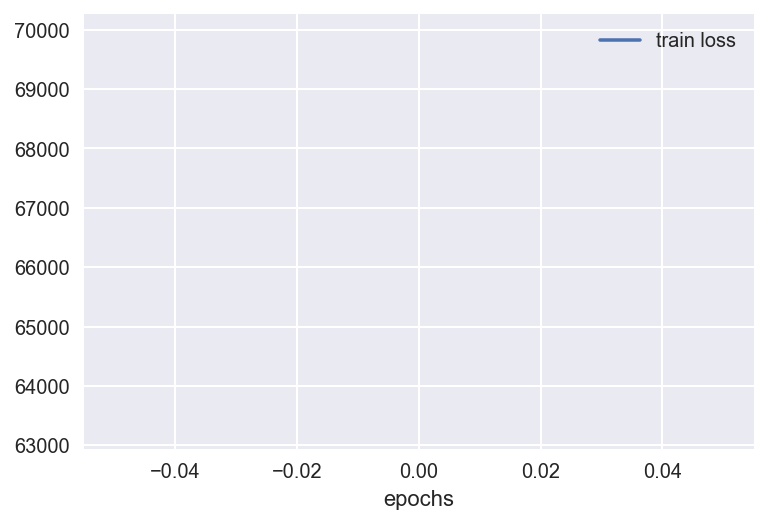

In [135]:
model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(.2))
model.add(Dense(int(X_train.shape[1]/2), activation="relu"))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, verbose=1)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.show();

In [136]:
preds = model.predict(X_test)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.00405239005635
4949.81207752


This is ever so slightly better than baseline, but not exactly inspirational, will try a convolutional Neural Net

In [128]:
X_train1 = np.expand_dims(X_train, axis=2)
X_test1 = np.expand_dims(X_test, axis=2)

print("Train: ", X_train1.shape, y_train.shape)
print("Test: ", X_test1.shape, y_test.shape)

Train:  (18014, 5052, 1) (18014,)
Test:  (6005, 5052, 1) (6005,)


Train on 18014 samples, validate on 6005 samples
Epoch 1/5
18014/18014 [==============================] - 69s 4ms/step - loss: 66591.7840 - val_loss: 5009.9213
Epoch 2/5
18014/18014 [==============================] - 69s 4ms/step - loss: 66623.9015 - val_loss: 5008.6429
Epoch 3/5
18014/18014 [==============================] - 67s 4ms/step - loss: 66622.2435 - val_loss: 5007.4387
Epoch 4/5
18014/18014 [==============================] - 67s 4ms/step - loss: 66620.5642 - val_loss: 5006.1619
Epoch 5/5
18014/18014 [==============================] - 67s 4ms/step - loss: 66618.8457 - val_loss: 5004.9200


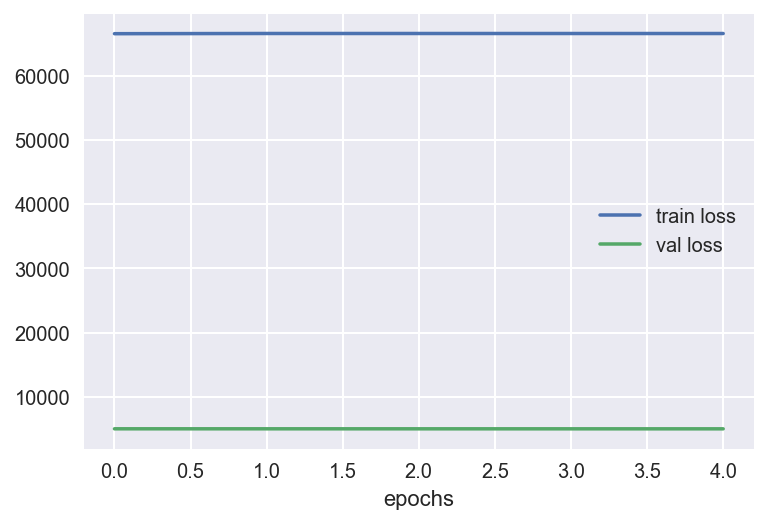

In [146]:
model = Sequential()
model.add(Conv1D(15, (6), input_shape=(5052, 1), activation='relu'))
model.add(MaxPool1D(2))
model.add(Conv1D(30, (4), activation='relu'))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train1, y_train, validation_data=(X_test1, y_test), epochs=5, verbose=1)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.show();

In [148]:
preds = model.predict(X_test1)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

-0.0070358943119
5004.92032151


Based on these results, I believe the few outliers in score are wildly throwing off the data. Deespite those being possible values, I am going to drop them all rows with ups above 250, essentially losing the ability to predict posts that get a massive amount of upvotes, but allowing the model to be much better at predicting the upvotes of an average post.

I will drop those values and then resplit my data.

In [161]:
df = pd.read_csv('data_checkpoint.csv')
df = df[df['ups'] < 250].copy()

X = df.drop('ups', axis=1)
y = df.ups

X_fulltrain, X_holdout, y_fulltrain, y_holdout = train_test_split(X, y, test_size=.1, random_state=337)
X_train, X_test, y_train, y_test = train_test_split(X_fulltrain, y_fulltrain, test_size=.25, random_state=337)

print("fulltrain: ", X_fulltrain.shape, y_fulltrain.shape)
print("holdout: ", X_holdout.shape, y_holdout.shape)
print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

fulltrain:  (23944, 14) (23944,)
holdout:  (2661, 14) (2661,)
Train:  (17958, 14) (17958,)
Test:  (5986, 14) (5986,)


Make a new baseline

In [172]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
preds = dr.predict(X_test)

print("r2: ", r2_score(y_test, preds))
print("MSE: ", mean_squared_error(y_test, preds))

r2:  -8.87827877278e-05
MSE:  151.11950214


In [162]:
%%time
X_train = data_transform_pipe.fit_transform(X_train)

CPU times: user 12min 45s, sys: 41.7 s, total: 13min 27s
Wall time: 5min 57s


In [163]:
%%time
X_test = data_transform_pipe.transform(X_test)

CPU times: user 1.92 s, sys: 1.1 s, total: 3.03 s
Wall time: 3.03 s


In [164]:
print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (17958, 5052) (17958,)
Test:  (5986, 5052) (5986,)


Train on 17958 samples, validate on 5986 samples
Epoch 1/3
17958/17958 [==============================] - 402s 22ms/step - loss: 152.3614 - val_loss: 134.7348
Epoch 2/3
17958/17958 [==============================] - 399s 22ms/step - loss: 106.9508 - val_loss: 148.8111
Epoch 3/3
17958/17958 [==============================] - 392s 22ms/step - loss: 76.1880 - val_loss: 166.5982


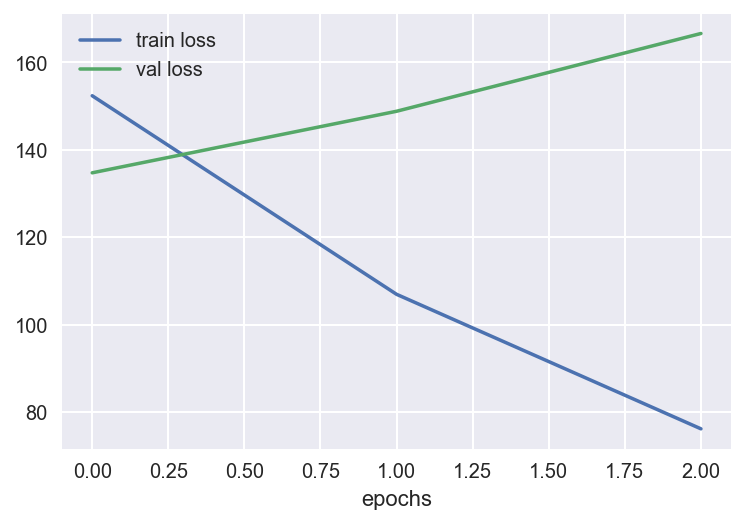

In [167]:
model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(.2))
model.add(Dense(int(X_train.shape[1]/2), activation="relu"))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, verbose=1)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.show();

In [169]:
preds = model.predict(X_test)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

-0.102524809749
166.598209293


Train on 17958 samples, validate on 5986 samples
Epoch 1/10
17958/17958 [==============================] - 7s 417us/step - loss: 145.1682 - val_loss: 136.5690
Epoch 2/10
17958/17958 [==============================] - 7s 396us/step - loss: 103.7234 - val_loss: 139.4603
Epoch 3/10
17958/17958 [==============================] - 7s 400us/step - loss: 77.8787 - val_loss: 143.7589
Epoch 4/10
17958/17958 [==============================] - 7s 398us/step - loss: 64.9432 - val_loss: 142.1988
Epoch 5/10
17958/17958 [==============================] - 7s 392us/step - loss: 62.3844 - val_loss: 149.3198
Epoch 6/10
17958/17958 [==============================] - 7s 393us/step - loss: 59.8949 - val_loss: 146.9877
Epoch 7/10
17958/17958 [==============================] - 7s 398us/step - loss: 57.0111 - val_loss: 151.1208
Epoch 8/10
17958/17958 [==============================] - 7s 401us/step - loss: 51.1234 - val_loss: 146.7188
Epoch 9/10
17958/17958 [==============================] - 7s 399us/step - los

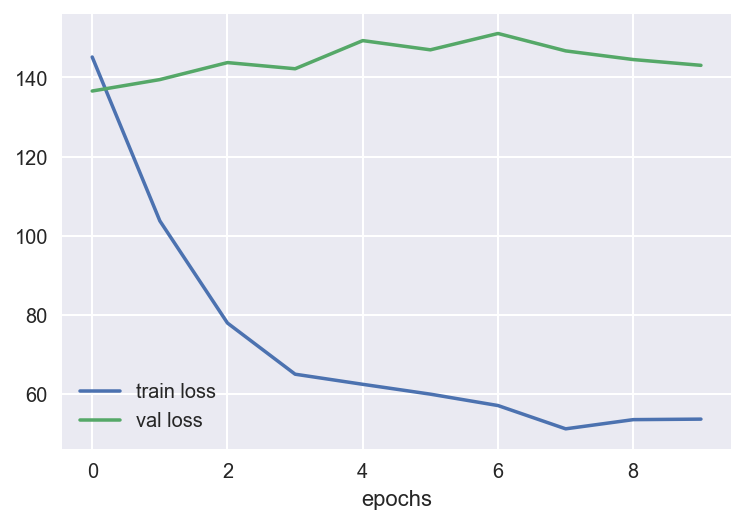

In [179]:
model = Sequential()
model.add(Dense(180, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(.25))
model.add(Dense(5, activation="relu"))
model.add(Dropout(.25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.show();

In [180]:
preds = model.predict(X_test)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.0532102259184
143.065697519


In [175]:
X_train1 = np.expand_dims(X_train, axis=2)
X_test1 = np.expand_dims(X_test, axis=2)

print("Train: ", X_train1.shape, y_train.shape)
print("Test: ", X_test1.shape, y_test.shape)

Train:  (17958, 5052, 1) (17958,)
Test:  (5986, 5052, 1) (5986,)


Train on 17958 samples, validate on 5986 samples
Epoch 1/10
17958/17958 [==============================] - 215s 12ms/step - loss: 164.0069 - val_loss: 160.6485
Epoch 2/10
17958/17958 [==============================] - 207s 12ms/step - loss: 155.7190 - val_loss: 158.4228
Epoch 3/10
17958/17958 [==============================] - 209s 12ms/step - loss: 153.7789 - val_loss: 156.5877
Epoch 4/10
17958/17958 [==============================] - 210s 12ms/step - loss: 152.2002 - val_loss: 155.0992
Epoch 5/10
17958/17958 [==============================] - 212s 12ms/step - loss: 150.9562 - val_loss: 153.9608
Epoch 6/10
17958/17958 [==============================] - 212s 12ms/step - loss: 150.0335 - val_loss: 153.1029
Epoch 7/10
17958/17958 [==============================] - 210s 12ms/step - loss: 149.3631 - val_loss: 152.4774
Epoch 8/10
17958/17958 [==============================] - 213s 12ms/step - loss: 148.8841 - val_loss: 152.0401
Epoch 9/10
17958/17958 [==============================] - 208s 

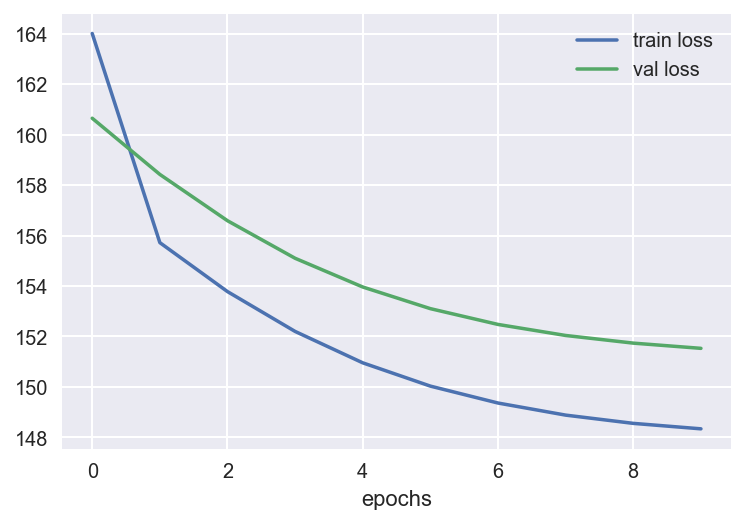

In [177]:
model = Sequential()
model.add(Conv1D(32, (6), input_shape=(5052, 1), activation='relu'))
model.add(MaxPool1D(2))
model.add(Conv1D(64, (4), activation='relu'))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(X_train1, y_train, validation_data=(X_test1, y_test), epochs=10, verbose=1)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.show();

In [178]:
preds = model.predict(X_test1)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

-0.00280653778742
151.530171462


Finally, am I being too enthusiastic and trying to force a Neural Net where it doesn't fit? Going to try a simpler ElasticNet, and then a GradientBoost.

In [181]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

In [183]:
#create parameters
en = ElasticNet()

params = {
    'alpha': np.linspace(0.01, 100, 3),
    'l1_ratio': np.linspace(0.01, 0.99, 3)
}

gs = GridSearchCV(en, params, verbose=1, cv=2, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  9.4min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([  1.00000e-02,   5.00050e+01,   1.00000e+02]), 'l1_ratio': array([ 0.01,  0.5 ,  0.99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [184]:
preds = gs.predict(X_test)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.00364757449913
150.554915813


In [187]:
#create parameters
gb = GradientBoostingRegressor()

params = {
    'max_depth':[5, 10],
    'max_features':['auto', 'sqrt'],
    'n_estimators': [25, 50]
}

gs = GridSearchCV(gb, params, verbose=2, cv=2, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] max_depth=5, max_features=auto, n_estimators=25 .................
[CV] max_depth=5, max_features=auto, n_estimators=25 .................
[CV] max_depth=5, max_features=auto, n_estimators=50 .................
[CV] max_depth=5, max_features=auto, n_estimators=50 .................
[CV] max_depth=5, max_features=sqrt, n_estimators=25 .................
[CV] max_depth=5, max_features=sqrt, n_estimators=25 .................
[CV] max_depth=5, max_features=sqrt, n_estimators=50 .................
[CV] max_depth=5, max_features=sqrt, n_estimators=50 .................
[CV] .. max_depth=5, max_features=sqrt, n_estimators=25, total=  22.4s
[CV] max_depth=10, max_features=auto, n_estimators=25 ................
[CV] .. max_depth=5, max_features=sqrt, n_estimators=25, total=  22.8s
[CV] max_depth=10, max_features=auto, n_estimators=25 ................
[CV] .. max_depth=5, max_features=sqrt, n_estimators=50, total=  29.0s
[CV] .. max_depth

[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:  8.4min remaining:  5.0min


[CV] .. max_depth=5, max_features=auto, n_estimators=50, total=13.1min
[CV] .. max_depth=5, max_features=auto, n_estimators=50, total=13.1min
[CV] . max_depth=10, max_features=auto, n_estimators=25, total=13.3min
[CV] . max_depth=10, max_features=auto, n_estimators=25, total=13.5min
[CV] . max_depth=10, max_features=auto, n_estimators=50, total=20.7min
[CV] . max_depth=10, max_features=auto, n_estimators=50, total=21.5min


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 22.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 10], 'max_features': ['auto', 'sqrt'], 'n_estimators': [25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [188]:
preds = gs.predict(X_test)

print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.0511898966489
143.370981569


In [189]:
print(gs.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 25}


Now fit all on the fulltraining data to get final results on holdout data. Will use the non Convolutional Neural Net

Baseline

In [194]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_fulltrain, y_fulltrain)
base_preds = dr.predict(X_holdout)

print("r2: ", r2_score(y_holdout, base_preds))
print("MSE: ", mean_squared_error(y_holdout, base_preds))

r2:  -0.000289029624609
MSE:  214.576045909


In [190]:
%%time
X_fulltrain = data_transform_pipe.fit_transform(X_fulltrain)

CPU times: user 15min 47s, sys: 48.7 s, total: 16min 36s
Wall time: 7min 21s


In [191]:
X_holdout = data_transform_pipe.transform(X_holdout)

In [200]:
gb = GradientBoostingRegressor(max_depth=10, max_features='sqrt', n_estimators=25)
gb.fit(X_fulltrain, y_fulltrain)

preds = gs.predict(X_holdout)

print(r2_score(y_holdout, preds))
print(mean_squared_error(y_holdout, preds))

0.0146830546874
211.364323541


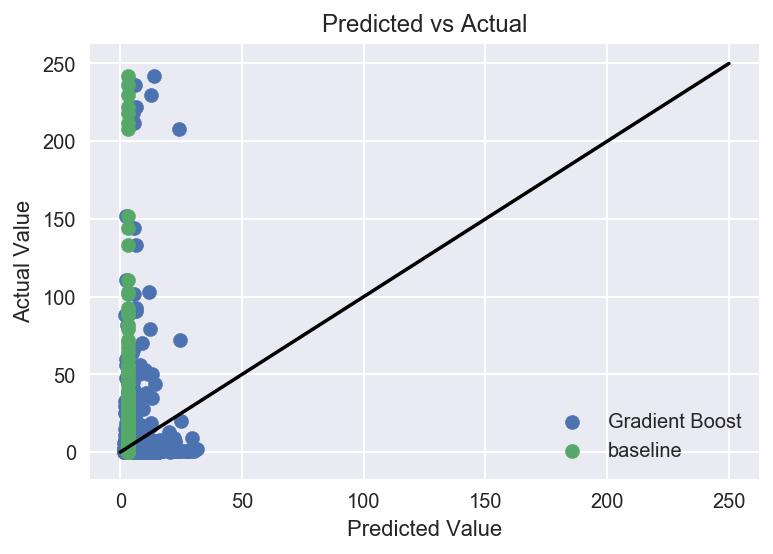

In [201]:
plt.scatter(preds, y_holdout, label='Gradient Boost')
plt.scatter(base_preds, y_holdout, label='baseline')
plt.plot((0,250), (0,250), color='black')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.legend()

In [208]:
rdf = pd.DataFrame()
rdf['actual'] = y_holdout
rdf['base_preds'] = base_preds
rdf['gb_preds'] = preds
rdf = rdf.sort_values('gb_preds')
rdf.reset_index(inplace=True)

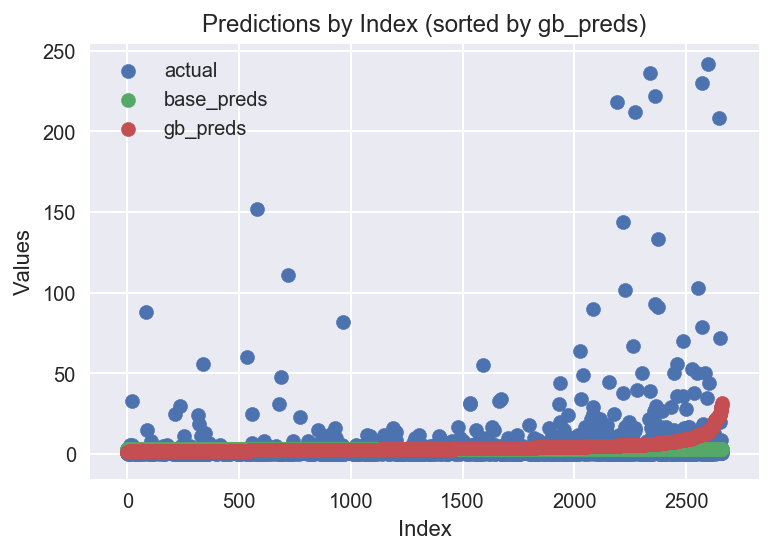

In [210]:
plt.scatter(rdf.index, rdf.actual)
plt.scatter(rdf.index, rdf.base_preds)
plt.scatter(rdf.index, rdf.gb_preds)
plt.title('Predictions by Index (sorted by gb_preds)')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

## Conclusion

I'm pretty dissapointed by how this turned out. I think being able to predict if a post will get lots of upvotes (which is directly related to how visible it will become to more people) can be a very valuable thing. For example, some companies have large portions of their community based in a subreddit, if you can predict what becomes popular it could let a Community Manager prioritize where they interact, which is one of the reasons I wanted to do it, but I do not feel like my final model accomplished that to a degree that is at all useful, being barely better than baseline.

Another issue I had, was I removed outliers based on the knowledge I thought I had of reddit, and now founded upon a mathematical basis.

### Next Steps

One possibility is to turn this into a classification problem. Reddit has a "Rising" page for subreddits that identify newer posts getting lots of activity. If I were to choose a certain amount of upvotes as a cutoff point and say anything below that is a 0 (unpopular) and above is 1 (popular) I think that may be a more promising and usefull model as opposed to predict the exact amount of exposure, I think it would also help against the fact that the vast majority of posts have 1 upvote (meaning only the person who made it upvoted it).

I would also like to see if I could get more/different data. For example, I think it would be interesting to take the subset of posts that make it to the "Rising" page, and try to predict which of those become popular, as opposed to trying to predict from brand new to posts. This would also be easier to predict accurately for the following reason: since I set my goal to be predicting from the creation of a post, I dropped the most predictive feature, the number of comments, so as not to look at the problem from the future. Looking at posts on the "Rising" page, they would already have some level of comments and upvotes since their creation, which would be incredibly useful metrics to look at for whether they would move on to popularity or fizz out.